In [30]:
import os
import pandas as pd 
import numpy as np 
from tqdm import tqdm
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt


BASE_DIR = r"C:\Users\Keelan.Butler\Desktop\python_projects\Final Project"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
ROUTE_DIR = r"C:\Users\Keelan.Butler\Desktop\python_projects\Final Project"
DATA_DIR = os.path.join(ROUTE_DIR,"Sentry-AI","Python")
FEATURE_PATH = os.path.join(BASE_DIR,"Dataset","features")
os.chdir(DATA_DIR)
df_train, df_test = pd.read_csv('Train_set.csv'),pd.read_csv('Test_set.csv')
# load features 
df_train_new, df_val = train_test_split(df_train, test_size=0.1, stratify=df_train['Anomaly_Type'], random_state=42)

def load_features(dataframe):
    """Function extracts features from dataframe and processes them for modelling.
    returns: features, anomaly, anomaly_bool, frame_number
    Arg:
    - dataframe: This will be our test/train dataset. 
    Returns: 
    - Features: Loaded features from corresponding npy file. 
    - anon_type: A break down on what anomaly has occured, otherwise Normal. 
    - anon_bool: A boolean of anomaly occurance.
    - start_frame: List of the corresponding final frame of the sliding window
    - end_frame: List of the corresponding final frame of the sliding window
    - video_names: List of video names, this enables up to partition by videos.
    """
    features = []
    anon_type = []
    anon_bool = []
    start_index = []
    end_index = []
    video_names = []
    for path,subdir, label, lab_bool, clip_start, clip_end, video_name in tqdm(zip(dataframe['feature_path'],dataframe['subfolder'], dataframe['Anomaly_Type'], dataframe['Anomaly'], dataframe['Start_of_Clip'], dataframe['End_of_Clip'], dataframe['name'])):
        feature = np.load(os.path.join(FEATURE_PATH,subdir,path)) # Accesses the relevant path through our relational database 
        features.append(feature) # List of loaded npy features.
        anon_type.append(label) # List of type of anomalies. 
        anon_bool.append(lab_bool) # 1 for anomaly, 0 for normal.
        video_names.append(video_name) # List of video names.
        start_index.append(clip_start) # List of clip start frame
        end_index.append(clip_end) # List of clip start frame
    return features, anon_type, anon_bool, start_index,end_index, video_names

train_features, train_anon_type, train_anon_bool, train_start_index,train_end_index, train_video_names = load_features(df_train_new)
val_features, val_anon_type, val_anon_bool, val_start_index,val_end_index, val_video_names = load_features(df_val)
test_features, test_anon_type, test_anon_bool, test_start_index, test_end_index, test_video_names = load_features(df_test)

l_encoder = LabelEncoder()
train_anon_type = l_encoder.fit_transform(train_anon_type)
val_anon_type = l_encoder.transform(val_anon_type)
test_anon_type = l_encoder.transform(test_anon_type)

class CLIP_DATA(Dataset):
    """Dataset class for clip-based video anomaly detection"""

    def __init__(self, features, anon_label, anon_bool):
        self.features = [torch.from_numpy(arr).float() for arr in features]  # Convert once
        self.anon_label = torch.tensor(anon_label, dtype=torch.long)  # Label-encoded anomaly type
        self.anon_bool = torch.tensor(anon_bool, dtype=torch.float32)  # Binary anomaly indicator (0 or 1)

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.anon_label[idx], self.anon_bool[idx]


training_data = CLIP_DATA(train_features, train_anon_type, train_anon_bool)
validation_data = CLIP_DATA(val_features, val_anon_type, val_anon_bool)
test_data = CLIP_DATA(test_features, test_anon_type, test_anon_bool)

train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
validation_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)



cpu


47880it [00:11, 4301.73it/s]
5321it [00:01, 5129.60it/s]
25670it [00:04, 5311.94it/s]


In [50]:
class AnomalyANN(nn.Module):
    """A feed forwards Neural Network to perform classification on the 
    spacial temporal data."""

    def __init__(self, input_size = 512, hidden_size = 1024, output_size = 1):
        super().__init__()
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size,int(hidden_size/2))
        self.fc3 = nn.Linear(int(hidden_size/2), output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self,x):
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.sigmoid(self.fc3(x))
        return x

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:40<00:00, 20.18s/it]


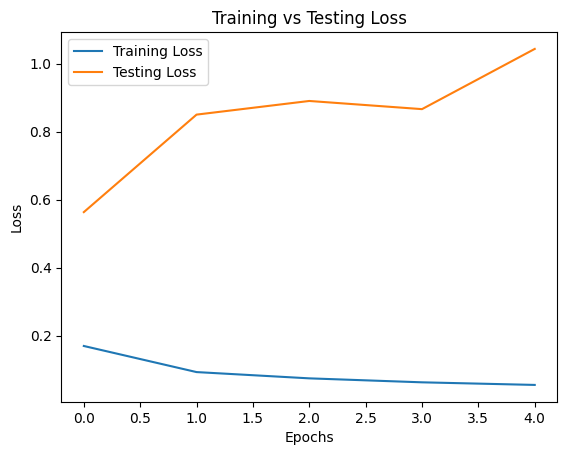

In [51]:
epochs = 5
loss_list = np.zeros((2, epochs))  # Store training & validation loss
model = AnomalyANN().to(device)  # Ensure model is on the correct device
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in tqdm(range(epochs)):  # Loop through epochs
    model.train()  # Set model to training mode
    total_loss = 0

    for batch in train_dataloader:
        features, _, labels = batch  # Extract features and labels
        features, labels = features.to(device), labels.to(device).unsqueeze(1)  # Move to device & reshape labels

        optimizer.zero_grad()  # Reset gradients
        outputs = model(features)  # Forward pass
        loss = criterion(outputs, labels.float())  # Compute loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

    avg_loss = total_loss / len(train_dataloader)
    loss_list[0, epoch] = avg_loss  # Store training loss

    # Validation Step
    model.eval()  # Set model to evaluation mode
    test_total = 0  # Initialize test loss accumulator

    with torch.no_grad():  # Disable gradients for validation
        for test_batch in test_dataloader:
            test_features, _, test_labels = test_batch
            test_features, test_labels = test_features.to(device), test_labels.to(device).unsqueeze(1)

            test_outputs = model(test_features)
            test_loss = criterion(test_outputs, test_labels.float())
            test_total += test_loss.item()  # Accumulate test loss

    avg_test_loss = test_total / len(test_dataloader)
    loss_list[1, epoch] = avg_test_loss  # Store validation loss

    #print(f"Epoch [{epoch+1}/{epochs}] - Train Loss: {avg_loss:.4f}, Test Loss: {avg_test_loss:.4f}")

# Plot Training vs Testing Loss
plt.plot(range(epochs), loss_list[0], label="Training Loss")
plt.plot(range(epochs), loss_list[1], label="Testing Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Testing Loss")
plt.show()


In [ ]:
gra